# Multi-armed bandit problem

### Задание
**1. Можно ли вычислить $Q_{t+1}(a)$ инкрементально (известно лишь  $Q_t(a)$ и награда  $r_{t+1}$, назначенная за выбор действия $a$)?**

Пусть $Q_t(a) = \frac{\sum_k r_{k}}{c_t(a)}$. При выборе на $t+1$-ом шаге действия $a:\; Q_{t+1}(a) =  \frac{\sum_k r_{k} \; + \; r_{t+1}}{c_t(a) + 1} = \frac{Q_{t}(a) \cdot c_t(a) \; + \; r_{t+1}}{c_t(a) + 1}$

### Построим для начала нашу модель:
#### Miscellaneous: некоторые глобальные импорты и вспомогательные функции
### Уточнение про warning'и:
Далее в коде matplotlib будет выкидывать предупреждения про функцию hold(). Смысл в том, что начиная с версии 2.0, matplotlib реализует plt.hold(True) по умолчанию, а на ручной вызов этой функции выдаёт warning. Поэтому ситуация такая: при полагании на поведение версии 1.x на старых версиях всё OK, на >=2.0 выдаётся warning, но графики чертятся правильно. При полагании на поведение >=2.0 на новых версиях всё OK, на старых всё ломается. Так как matplotlib 2.0 стоит пока что не у всех (например, я обновил версию буквально пару недель назад), в дальнейшем я буду полагаться на старое поведение, поэтому в коде будут warning'и

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.ndimage.filters import gaussian_filter1d

# Код для отображения прогресс-бара, спасибо https://github.com/alexanderkuk
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

#### Класс, представляющий среду
Имеет один метод, отдающий награду за действие

In [2]:
class MAB_Model:
    def __init__(self, actions):
        self.actions = actions
        self.reward_means = np.random.normal(size=actions)
    def get_reward(self, action):
        return np.random.normal(self.reward_means[action])

#### Базовый класс, определяющий основные методы стратегии

In [3]:
class MAB_Strategy:
    def __init__(self, model):
        self.model = model
        self.reward_means = np.zeros((model.actions))
        self.action_uses = np.zeros((model.actions))
    def make_step(self): # Returns reward
        pass
    def update_reward(self, action, reward):
        self.reward_means[action] = (self.reward_means[action] * self.action_uses[action] + reward)\
        / (self.action_uses[action] + 1)
        self.action_uses[action] += 1
    def best_actions(self):
        best =  np.argwhere(self.reward_means == np.max(self.reward_means))
        return best.reshape(best.shape[0])

#### Класс для запуска и тестирования эффективности стратегий

In [4]:
class Player:
    def __init__(self, actions, steps, strategy_class, **kwargs):
        self.actions = actions
        self.strategy_class = strategy_class
        self.steps = steps
        self.strategy_args = kwargs
    def play(self):
        model = MAB_Model(self.actions)
        strategy = self.strategy_class(model, **(self.strategy_args))
        rewards = np.zeros(self.steps)
        optimum = np.zeros(self.steps)
        rewards[0] = strategy.make_step()
        optimum[0] = model.reward_means.max()
        for i in range(1, self.steps):
            rewards[i] = strategy.make_step()
            rewards[i] += rewards[i-1]
            optimum[i] = model.reward_means.max()
            optimum[i] += optimum[i-1]
        return rewards, optimum
    def visualize(self, rewards, optimum, hold, show, show_opt, smoothen, color, label_loc):
        if not hold:
            plt.figure(figsize=(8, 7))
        x = np.arange(1, self.steps+1)
        if show_opt:
            plt.plot(x, optimum, 'k', label='optimum')
        plot_rewards = rewards
        if (smoothen):
            plot_rewards = rewards.copy()
            plot_rewards = gaussian_filter1d(plot_rewards, 10.0)
        plt.plot(x, plot_rewards, color, label=self.strategy_class.__name__)
        plt.title('Total reward', fontsize=16)
        if not hold:
            plt.legend(loc=label_loc, fontsize=14)
            plt.xlabel('steps')
            plt.ylabel('total reward')
            plt.grid(True)
            plt.show()
        
    def evaluate(self, games=1000, progressbar=True,hold=False, show=True,
                 show_opt=True, smoothen=False, color='b', label_loc='upper left'):
        rewards = np.zeros(self.steps)
        optimum = np.zeros(self.steps)
        if progressbar:
            games_range = log_progress(range(games), every=10)
        else:
            games_range = range(games)
        rewards = np.zeros(self.steps)
        optimum = np.zeros(self.steps)
        for game in games_range:
            res = self.play()
            rewards += res[0] / games
            optimum += res[1] / games
        if show:
            self.visualize(rewards, optimum, hold, show, show_opt, smoothen, color, label_loc)
        return rewards.sum()  / optimum.sum()

### Реализуем жадную стратегию

In [5]:
class Greedy(MAB_Strategy):
    def __init__(self, model):
        MAB_Strategy.__init__(self, model)
    def make_step(self):
        best = self.best_actions()
        action = np.random.choice(best)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

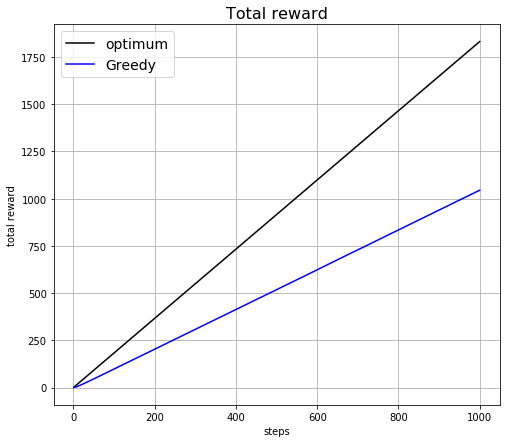

Total reward: 57.0% of best possible result


In [6]:
player = Player(20, 1000, Greedy)
result = player.evaluate(games=1000)
print('Total reward:', str(round(result*100)) + "% of best possible result")

Её основной недостаток достаточно очевиден: сначала действия выбираются абсолютно случайно, и если на первом шаге алгоритм выберет "плохой" автомат, но на котором случайно выпал хороший выигрыш, он так и продолжит на нём играть, и переключится на другие автоматы только тогда, когда средний выигрыш на автомате станет неположительным. Кроме того, если выигрыш будет положителен, но мал, алгоритм так и продолжит использовать этот автомат, даже если есть более выгодные автоматы.

В качестве начальной стратегии использовался просто случайный выбор автомата.

Конечно же, из указанных выше соображений было бы неплохо провести начальную серию игр для того, чтобы собранная информация в большей степени соответствовала реальному матожиданию выигрыша на каждом автомате. Кроме того, очевидно, что у автомата с большим матожиданием выигрыша вероятность выпадения высокого слычайного выигрыша больше, чем у автомата с меньшим матожиданием выигрыша, поэтому выбор автомата с наибольшим выигрышем вместо случайного автомата в среднем должно улучшать результат

Для наглядности запустим аналогичную симуляцию, но в которой для каждого запуска алгоритм предварительно дважды дёргал за ручку каждого автомата:

In [7]:
class InitializingPlayer(Player):
    def play(self):
        model = MAB_Model(self.actions)
        strategy = self.strategy_class(model, **(self.strategy_args))
        rewards = np.zeros(self.steps)
        optimum = np.zeros(self.steps)
        for action in range(1, self.actions):
            reward = strategy.model.get_reward(action)
            strategy.update_reward(action, reward)
            rewards[action] += reward
            optimum[action] += model.reward_means.max()
            if action != 0:
                rewards[action] += rewards[action-1]
                optimum[action] += optimum[action-1]
        for i in range(self.actions, self.steps):
            rewards[i] = strategy.make_step()
            rewards[i] += rewards[i-1]
            optimum[i] = model.reward_means.max()
            optimum[i] += optimum[i-1]
        return rewards, optimum

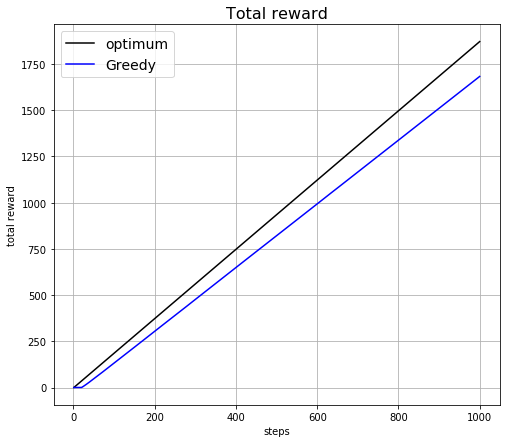

Total reward: 88.0% of best possible result


In [8]:
player = InitializingPlayer(20, 1000, Greedy)
result = player.evaluate(games=1000)
print('Total reward:', str(round(result*100)) + "% of best possible result")

Однако можно заметить, что очень похожего результата можно добиться, если инициализировать вектор средних наград не нулями, а достаточно большими числами (в данном случае - 20), которые с достаточно большой вероятностью будут больше выпадающей награды. Таким образом, с вероятностью, близкой к 1, при первом выборе автомата его средняя награда станет меньше 20. Таким образом, в начале запуска стратегия переберёт все автоматы по одному разу и лишь затем начнёт играть жадно:

In [9]:
class Greedy10(MAB_Strategy):
    def __init__(self, model):
        MAB_Strategy.__init__(self, model)
        self.reward_means.fill(20)
    def make_step(self):
        best = self.best_actions()
        action = np.random.choice(best)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

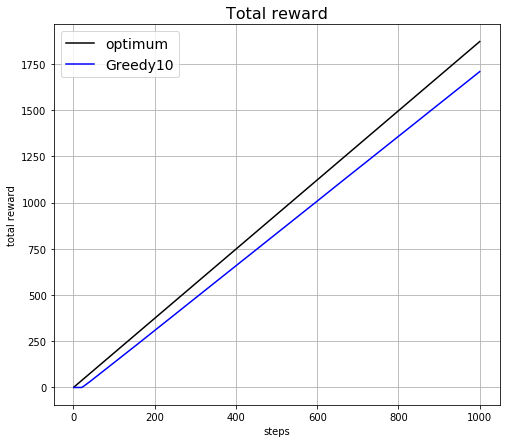

Total reward: 89.0% of best possible result


In [10]:
player = Player(20, 1000, Greedy10)
result = player.evaluate(games=1000)
print('Total reward:', str(round(result*100)) + "% of best possible result")

### $\varepsilon$ -greedy стратегия

In [11]:
class E_Greedy(MAB_Strategy):
    def __init__(self, model, eps):
        MAB_Strategy.__init__(self, model)
        self.eps = eps
    def make_step(self):
        best = (self.reward_means == np.max(self.reward_means))
        proba = (1-self.eps) * best / best.sum()
        proba += self.eps * np.ones((self.model.actions)) / self.model.actions
        action = np.random.choice(self.model.actions, p=proba)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

В данной стратегии $\varepsilon$ отвечает за "любознательность" стратегии: чем значение больше, тем меньше стратегия будет оглядываться на предыдущие результаты и тем активнее выбирать случайный автомат. При $\varepsilon = 1$ стратегия вообще не будет учитывать средние награды и будет выбирать автоматы случайным образом. При $\varepsilon = 0$ наоборот, стратегия превратится в обыкновенную жадную

### Softmax

In [12]:
class Softmax(MAB_Strategy):
    def __init__(self, model, eps):
        MAB_Strategy.__init__(self, model)
        self.eps = eps
    def make_step(self):
        proba = np.exp( (self.reward_means - np.max(self.reward_means)) / self.eps)
        proba = proba / proba.sum()
        action = np.random.choice(self.model.actions, p=proba)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

Здесь тоже при $\varepsilon \rightarrow 0$ мы увеличиваем значения степеней в выражении, и
$\pi_{t+1}(a) \rightarrow \{a = \arg \max Q_t(a)\}$

В то же время при $\varepsilon \rightarrow \infty : \; \forall a \; \frac {Q_t(a)}{\varepsilon} \rightarrow 0,\; e^{<...>} \rightarrow 1,\; \pi_{t+1}(a) \rightarrow \frac{1}{|A|}$

### Upper Confidence Bound

In [13]:
class UCB(MAB_Strategy):
    def __init__(self, model, eps):
        MAB_Strategy.__init__(self, model)
        self.eps = eps
        self.step = 0
    def make_step(self):
        value = self.reward_means.copy()
        value += self.eps * np.sqrt(2 * math.log(self.step + 1) / (self.action_uses + 0.001))
        self.step += 1
        best =  np.argwhere(value == np.max(value))
        best = best.reshape(best.shape[0])
        action = np.random.choice(best)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

Тут с $\varepsilon$ тоже всё очевидно: при $\varepsilon \rightarrow \infty$ важность того, с какой частотой мы использовали автомат, увеличивается и вскоре начинает перевешивать важность известной средней награды, в результате стратегия опять превращается в случайную, причём не в абсолютно случайную, а с повышенной вероятностью выбора малопосещаемых автоматов

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:44: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


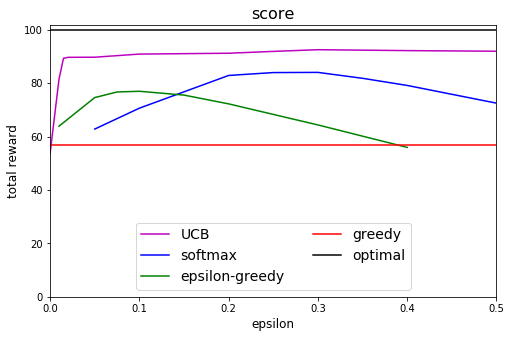

In [14]:

# ATTENTION: takes a significant amount of time to be processed
games_num = 1000

player = Player(20, 1000, Greedy)
result = player.evaluate(games=games_num, show=False) * 100
greedy_sum = result

egreedy_epsilons = [0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4]
egreedy_results = []
for e in log_progress(egreedy_epsilons, every=1):
    player = Player(20, 1000, E_Greedy, eps=e)
    res = player.evaluate(games=games_num, show=False, progressbar=False) * 100
    egreedy_results.append(res)
    
softmax_epsilons = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
softmax_results = []
for e in log_progress(softmax_epsilons, every=1):
    player = Player(20, 1000, Softmax, eps=e)
    res = player.evaluate(games=games_num, show=False, progressbar=False) * 100
    softmax_results.append(res)
    
ucb_epsilons = [0, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
ucb_results = []
for e in log_progress(ucb_epsilons, every=1):
    player = Player(20, 1000, UCB, eps=e)
    res = player.evaluate(games=games_num, show=False, progressbar=False) * 100
    ucb_results.append(res)

plt.figure(figsize=(8, 5))
plt.title('score', fontsize=16)
plt.axis([0, max(egreedy_epsilons[-1], softmax_epsilons[-1], ucb_epsilons[-1]),
          0, max(*egreedy_results, *softmax_results, *ucb_results)*1.1])
plt.xlabel('epsilon', fontsize=12)
plt.ylabel('total reward', fontsize=12)
plt.hold(True)
plt.plot(ucb_epsilons, ucb_results, 'm', label='UCB', linewidth=1.5)
plt.plot(softmax_epsilons, softmax_results, 'b', label='softmax', linewidth=1.5)
plt.plot(egreedy_epsilons, egreedy_results, 'g', label='epsilon-greedy', linewidth=1.5)
plt.plot([0, max(softmax_epsilons[-1], egreedy_epsilons[-1])], [greedy_sum, greedy_sum],
         'r', label='greedy', linewidth=1.5)
plt.plot([0, max(softmax_epsilons[-1], egreedy_epsilons[-1])], [100.0, 100.0],
         'k', label='optimal', linewidth=1.5)
plt.hold(False)
plt.legend(loc='lower center', fontsize=14, ncol=2)
plt.show()

Таким образом, мы определили наилучшие коэффициенты $\varepsilon$ для алгоритмов -  $\varepsilon=0.1$ для $\varepsilon-greedy$, $\varepsilon=0.25$ для $softmax$ и $\varepsilon=0.25$ для $UCB$ и проверили превосходство UCB над прочими алгоритмами. Кроме того, заметно, что $UCB$ гораздо менее чувствителен к изменению параметров

### Градиентный метод

In [15]:
class Gradient(MAB_Strategy):
    def __init__(self, model, lambd):
        MAB_Strategy.__init__(self, model)
        self.lambd = lambd
        self.priorities = np.zeros((model.actions))
        self.step = 1
    def update_reward(self, action, reward):
        old_rewards = self.reward_means.copy()
        proba = np.exp(self.priorities - np.max(self.priorities))
        proba = proba / proba.sum()
        self.reward_means += 1 / self.step * (reward - self.reward_means)
        is_current_action_mask = np.zeros((self.model.actions))
        is_current_action_mask[action] += 1
        self.priorities += self.lambd * (reward - old_rewards) * (is_current_action_mask - proba)
    def make_step(self):
        proba = np.exp(self.priorities - np.max(self.priorities))
        proba = proba / proba.sum()
        action = np.random.choice(self.model.actions, p=proba)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        self.step += 1
        return reward

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


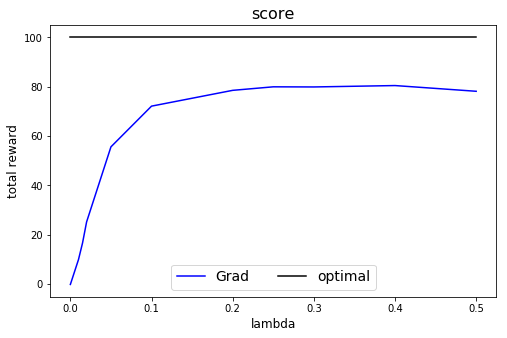

Max result: 8045.67096434%


In [16]:
grad_epsilons = [0, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
grad_results = []
for e in log_progress(grad_epsilons, every=1):
    player = Player(20, 1000, Gradient, lambd=e)
    res = player.evaluate(games=1000, show=False, progressbar=False) * 100
    grad_results.append(res)

plt.figure(figsize=(8, 5))
plt.title('score', fontsize=16)
plt.xlabel('lambda', fontsize=12)
plt.ylabel('total reward', fontsize=12)
plt.hold(True)
plt.plot(grad_epsilons, grad_results, 'b', label='Grad', linewidth=1.5)
plt.plot([0, grad_epsilons[-1]], [100, 100],
         'k', label='optimal', linewidth=1.5)
plt.hold(False)
plt.legend(loc='lower center', fontsize=14, ncol=2)
plt.show()
print("Max result:", str(max(grad_results)*100) + "%")

Отсюда выберем параметр $\lambda = 0.2$. Сравним теперь этот метод с предыдущими в динамике:

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


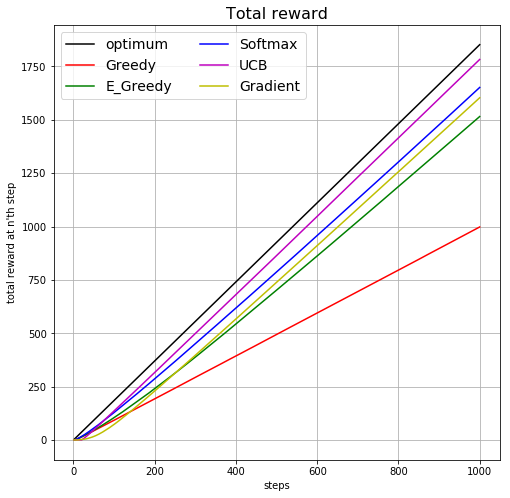

In [21]:
games_num = 1000

plt.figure(figsize=(8, 8))
plt.xlabel('steps')
plt.ylabel("total reward at n'th step")
plt.hold(True)
greedy_player = Player(20, 1000, Greedy)
greedy_player.evaluate(games=games_num, show=True, hold=True, color='r', show_opt=True)
e_greedy_player = Player(20, 1000, E_Greedy, eps=0.1)
e_greedy_player.evaluate(games=games_num, show=True, hold=True, color='g', show_opt=False)
softmax_player = Player(20, 1000, Softmax, eps=0.25)
softmax_player.evaluate(games=games_num, show=True, hold=True, color='b', show_opt=False)
ucb_player = Player(20, 1000, UCB, eps=0.25)
ucb_player.evaluate(games=games_num, show=True, hold=True, color='m', show_opt=False)
grad_player = Player(20, 1000, Gradient, lambd=0.2)
grad_player.evaluate(games=games_num, show=True, hold=True, color='y', show_opt=False)
plt.hold(False)
plt.grid(True)
plt.legend(loc='upper left', ncol=2, fontsize=14)
plt.show()